# Options Pricing


_Derivatives are financial weapons of mass destruction_ - Warren Buffett

We explore the basics of options, common strategies, and the foundational pricing models used in the financial markets. The price of an option is influenced by various factors, including the underlying asset's price, the time remaining until expiration, the volatility of the asset, interest rates, and the strike price. 
The valuation of options can be approached through techniques like binomial tree pricing and Monte Carlo simulations, or models like the Black-Scholes-Merton model.


In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from finds.utils import row_formatted
from finds.readers import Alfred
from secret import credentials
VERBOSE = 0
#%matplotlib qt

## Options

An **European** call or put option grants the buyer the right to buy or sell an asset at a specified price on a given expiration date. An **American** call or put option, on the other hand, allows the buyer to exercise the option at any time before or on the expiration date. The specified date is known as the **expiration** (or **maturity**) date, while the price at which the asset can be traded is referred to as the **strike** (or **exercise**) price.

Options can be categorized based on their **moneyness**, meaning the relationship between the option's strike price and the current price of the underlying asset. An option is considered **in-the-money** if it would result in a positive payoff if exercised immediately, **out-of-the-money** if it would lead to a negative payoff, and **at-the-money** if the strike price equals the current market price.

The value of an option depends on several factors, including:
- The price of the underlying asset (S)
- The strike price (K)
- The risk-free rate (r)
- The volatility of the asset's price ($\sigma$)
- The time to maturity (T)
- Any dividends to be paid during the life of the option (q)

Put-call parity defines the relationship between the prices of European call and put options with identical strike prices and expiration dates: $S - C = PV(K) - P$.



### Option strategies

Various trading strategies involve entering positions in multiple options simultaneously, and sometimes incorporating the underlying asset.

- A **protective put** strategy involves buying a put option while holding the underlying asset. This combined position offers a payoff similar to that of a call option, along with the amount of cash equivalent to the present value of the strike price.
  
- A **covered call** strategy entails owning an asset and selling a call option on it. Typically, the call option is out-of-the-money, and the strategy generates income from the option premium while sacrificing potential upside gains beyond the strike price.
  
- A **bull spread** is employed by an investor expecting an increase in the asset's price. The strategy involves buying a European call with a lower strike price (K1) and selling a European call with a higher strike price (K2).
  
- A **bear spread** involves buying a European put option with a higher strike price (K2) and selling a European put option with a lower strike price (K1).

- A **box spread** is a portfolio consisting of a bull spread (using call options) and a bear spread (using put options). Both spreads use the same strike prices and expiration dates.

- A **butterfly spread** involves a combination of three options, created using either calls or puts. A common version involves one long call with a lower strike price (K1), one long call with a higher strike price (K3), and two short calls at a strike price (K2), where $K2 = (K1 + K3) / 2$.

- A **calendar spread** strategy consists of buying a long call option with an expiration date at time T* and selling a short call option with an earlier expiration date, both at the same strike price (K).

- A **straddle** is created by holding both a long call and a long put with the same strike price and expiration date.

- A **strangle** is similar to a straddle but reduces the cost by selecting a call option with a higher strike price than the put option.



In [2]:
# define call and put payoffs at maturity
def call_payoff(K):
    return lambda s: s - K if s > K else 0

def put_payoff(K):
    return lambda s: K - s if s < K else 0

In [3]:
# helpers to plot final payoff of option strategy
def plot_payoff(payoff, S=np.linspace(70, 130, 60), ax=None, label=''):
    """helper to plot final payoff over range of stock price S"""
    ax = ax or plt.gca()
    df = DataFrame([payoff(s) for s in S], index=S)
    zeros = (df == 0).all(axis=0)
    df = df.drop(columns=df.columns[zeros])
    df = df + np.sign(df.sum(axis=0))*0.4    # jigger so can display separate
    y = df.sum(axis=1).rename(label)
    y.plot(ax=ax, lw=3)
    df.plot(marker='.', ls='', ms=4, ax=ax)
    ax.legend([label] + list(df.columns))

def _ls(n):
    """helper to label as long or short position"""
    return 'long' if n >=0 else 'short'

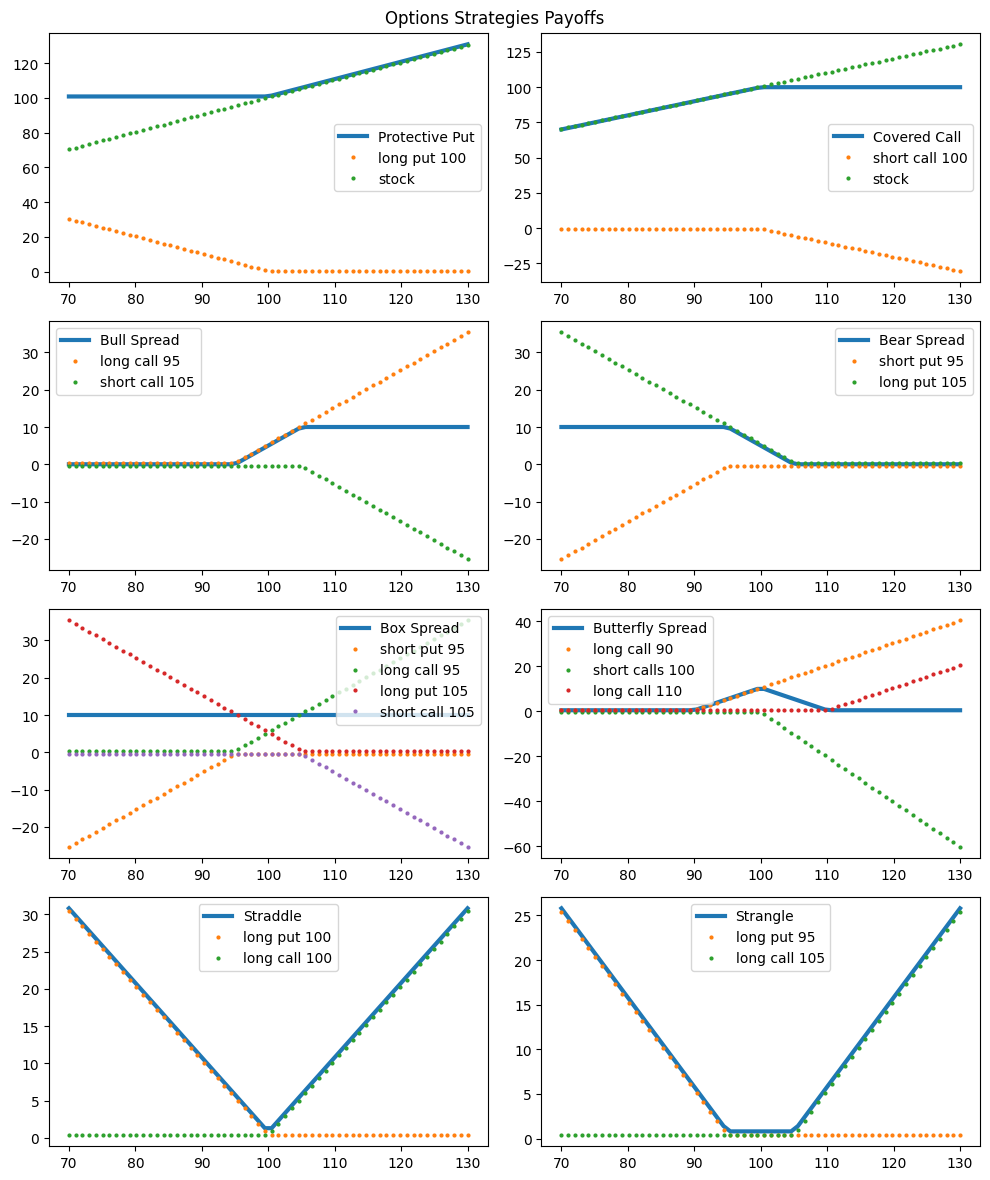

In [4]:
# Define and plot the options strategies
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
ax = ax.flatten()

def options_strategy(K, calls=0, puts=0, stocks=0):
    return lambda s: {f"{_ls(calls)} call {K}": calls*call_payoff(K)(s),
                      f"{_ls(puts)} put {K}": puts*put_payoff(K)(s),
                      "stock": stocks*s}

plot_payoff(options_strategy(K=100, puts=1, stocks=1), ax=ax[0], label='Protective Put')

plot_payoff(options_strategy(K=100, calls=-1, stocks=1), ax=ax[1], label='Covered Call')

def bull_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"long call {K1}": call_payoff(K1)(s),
                      f"short call {K2}": -call_payoff(K2)(s)}

plot_payoff(bull_spread(K1=95, K2=105), ax=ax[2], label='Bull Spread')

def bear_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"short put {K1}": -put_payoff(K1)(s),
                      f"long put {K2}": put_payoff(K2)(s)}

plot_payoff(bear_spread(K1=95, K2=105), ax=ax[3], label='Bear Spread')

def box_spread(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"short put {K1}": -put_payoff(K1)(s),
                      f"long call {K1}": call_payoff(K1)(s),
                      f"long put {K2}": put_payoff(K2)(s),
                      f"short call {K2}": -call_payoff(K2)(s)}

plot_payoff(box_spread(K1=95, K2=105), ax=ax[4], label='Box Spread')

def butterfly_spread(K1, K3):
    assert K3 > K1, "K3 must be greater than K1"
    K2 = (K1 + K3) / 2
    return lambda s: {f"long call {K1}": call_payoff(K1)(s),
                      f"short calls {K2:g}": -2*call_payoff(K2)(s),
                      f"long call {K3}": call_payoff(K3)(s)}

plot_payoff(butterfly_spread(K1=90, K3=110), ax=ax[5], label='Butterfly Spread')

def straddle(K):
    return lambda s: {f"long put {K}": put_payoff(K)(s),
                      f"long call {K}": call_payoff(K)(s)}                      
plot_payoff(straddle(K=100), ax=ax[6], label='Straddle')

def strangle(K1, K2):
    assert K2 > K1, "K2 must be greater than K1"
    return lambda s: {f"long put {K1}": put_payoff(K1)(s),
                      f"long call {K2}": call_payoff(K2)(s)}
plot_payoff(strangle(K1=95, K2=105), ax=ax[7], label='Strangle')

plt.suptitle('Options Strategies Payoffs')
plt.tight_layout()

### Exotic options

In addition to standard European and American options (which are termed plain vanilla options), there are **exotic options** (or simply **exotics**) which have more complex structures and non-standard features.

- A **Bermudan** option is one where the exercise of the option is restricted to certain predetermined dates.

- A **forward start** option is an option that starts at a future date and is usually at-the-money at the time it begins.

- A **gap** option is a European option where the price triggering a payoff is different from the price used to calculate the payoff.

- A **cliquet** option is a series of forward start options, each with its own rules for determining strike prices.

- **Binary** options (also called **digital** options) pay a fixed amount or asset if the option's price exceeds (or falls below) the strike price, otherwise, they pay nothing.

- **Asian** options provide payoffs based on the arithmetic average of the asset’s price during the option’s life.

- A **lookback** option’s payoff depends on the maximum or minimum price reached by the asset during its lifetime. A floating lookback option gives a payoff based on the difference between the final asset price and the minimum (or maximum) price reached, while a fixed lookback option bases the payoff on the difference between the maximum (or minimum) price and the strike price.

- **Barrier** options have payoffs that depend on whether the price of the asset reaches a specific level, with various types like down-and-out, down-and-in, up-and-out, and up-and-in.

- A **compound** option is an option on another option, which results in two strike prices and two expiration dates.

- An **asset-exchange** option allows the holder to exchange one asset for another.

- A **volatility swap** is a forward contract based on the realized volatility of an asset during a specified period. Traders exchange the realized volatility at the end of the period for a pre-specified volatility rate.




- The exercise of a __Bermudan__ option is restricted to certain dates.

- A __forward start__ option is an option that will begin at a future time. It is usually stated that the option will be at-the-money at the time it starts. 

- A __gap__ option is a European call or put option where the price triggering a payoff is different from the price used in calculating the payoff.

- A __cliquet__ option is a series of forward start options with certain rules for determining the strike prices.

- __Binary__ call (put) options may a fixed amount of cash or an asset when its price is above (below) the strike price, or nothing otherwise.  Cash-or-nothing optinos are sometimes referred to as __digital__ options.

- __Asian__ options provide a payoff dependent on an arithmetic aver-age of the underlying asset price during the life of the option. 

- The payoff from a __lookback__ option depends on the maximum or minimum asset price reached during the life of the option. A floating lookback call (put) gives a payoff equal difference between the final asset price and minimum (maximum) price. The payoff of a fixed lookback call (put) is based on the difference betwen the maximum (minimum) price and the strike price.

- __Barrier__ options come into existence or ceases to exist depending on whether the asset price reaches a particular barrier.  There are down-and-out, down-and-in, up-and-out and up-and-in variants.

- A __compound__ option is an option on another option. Thus, there are two strike prices and two maturity dates.

- In an __asset-exchange__ option, the holder has the right to exchange one asset for another. 

- A __volatility swap__ is a forward contract on the realized volatility of an asset during a certain period. A trader agrees to exchange a pre-specified volatility for the realized volatility at the end of the period.


## Binomial option pricing

The **binomial option pricing model**, proposed by Cox, Ross, and Rubinstein (1979), is widely used to value American-style options and other derivatives.

### No-arbitrage

The no-arbitrage principle assumes there are no opportunities for riskless profit in the market. The **law of one price** stipulates that if two portfolios produce the same cash flows at the same times, they should have the same price. Binomial trees use this no-arbitrage principle to model option pricing.

For example, assuming a non-dividend-paying stock with price $S$, the stock can either increase to $Su$ or decrease to $Sd$ within time T. The portfolio is structured with:
- A short position in the derivative, and
- A position in the stock which we set equal to $\Delta = \dfrac{f_u - f_d}{S u - S d}$

The value of the portfolio at time T is
- $S u \Delta - f_u$ if the stock price increases, and 
- $S d \Delta - f_d$ if the stock price decreases. 

The value of the portfolio today is $S \Delta - f$, where f is the value of the derivative today. Suppose r is the risk-free rate for maturity T. For no arbitrage, we must have

$S \Delta - f = \dfrac{f_ud - f_du}{u - d}e^{-rT}$

Substituting for $\Delta$, gives: 

$$f = e^{-rT}[pf_u + (1 - p)f_d]$$

where $p = \dfrac{e^{rT} - d}{u - d}$



### Risk neutral pricing

Suppose we choose to interpret the variable p as the probability of an upward movement (with 1 - p being the probability of a downward movement), then the expected stock price grows at the risk-free rate. It also means that $p$ is the probability of an upward movement in a risk-neutral world.

The **risk-neutral** valuation approach applies a probability $p$ for upward movements and values the option by its expected payoff, discounted at the risk-free rate. Risk-neutral pricing assumes that all assets earn the risk-free rate of return in the market. Put another way, a risk-neutral world is one where all tradable assets have an expected return equal to the risk-free interest rate. The probabilities of different outcomes in a risk-neutral world are therefore based on this assumption, and a risk-neutral investor has no preference between assets with different risks. This methodology simplifies the valuation process by treating all market participants as indifferent to risk.

It should be emphasized that the risk-neutral valuation is nothing more than an artificial way of valuing derivatives. We are not assuming that the world is actually risk-neutral. We are instead arguing that the price of a derivative is the same in the real world as it would be in the risk-neutral world


### Binomial tree
In practice, the binomial model is extended to multi-step trees, where each step reflects changes in the asset's price over time. Parameters like $\Delta t$ (time between steps), and $u$, $d$ (upward and downward movements) are chosen based on the asset's volatility:

- the length of a tree step as $\Delta t$
- the parameters u and d should be chosen to reflect the volatility of
  the stock price. If we denote the volatility per year by $\sigma$, then appropriate values for the parameters are 
  - $u = e^{\sigma \sqrt{\Delta t}}$
  - $u = e^{-\sigma \sqrt{\Delta t}}$

  where $\Delta t$ is measured in years.
- hence 
  $$f = e^{-r \Delta t} [p f_u + (1 - p) f_d]$$
  where $p = \dfrac{e^{r \Delta t} - d}{u - d}$

- the delta, or position taken in the stock to hedge a short posion
  in the derivative, is $\Delta = \dfrac{f_u - f_d}{Su - Sd}$


__Dividends__: For assets paying dividends, the probability $p$ is adjusted to account for the dividend yield $q$:

$$p = \dfrac{e^{(r - q)\Delta t} - d}{u - d}$$

__Currency Options__: A currency can be considered as an asset providing a yield at the foreign risk-free rate. Therefore, the analysis we presented for a stock paying a continuous dividend yield applies, with q equal to the foreign risk-free rate. 

__Futures__: Because it costs nothing to enter into a futures contract, the return on a futures contract in a risk-neutral world must be zero. This means we can treat a futures contract like a stock, paying a continuous dividend yield equal to the risk free rate. 


In [5]:
def binomial_tree(S, sigma, r, T, steps, payoff=None, q=0, american=False,
                  verbose=True):
    delta_t = T / steps    
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp((r - q) * delta_t) - d) / (u - d)
    result = dict(value=None, u=u, d=d, p=p, delta_t=delta_t)
    if payoff is not None:
        label = "STEP {:<5d}".format    # to label output of each step

        # initialize price vectors at last step
        prices = DataFrame(0.0, index=np.arange(steps+1),
                           columns=['stock', 'option', 'delta'])
        for downs in range(steps+1):
            s = d**downs * u**(steps-downs) * S      # price after number of downs
            prices.loc[downs, 'stock'] = s
            prices.loc[downs, 'option'] = payoff(s)  # option value at expiry
        print(row_formatted(prices.T.rename_axis(columns=label(steps)),
                            default="{:.4f}"))
        
        # roll back one time step at a time
        for step in range(steps - 1, -1, -1):

            # update all scenarios in this time step
            for downs in range(step+1):

                # stock price after this number of downs
                s = d**downs * u**(step - downs) * S  
                prices.loc[downs, 'stock'] = s
                
                # value of option is max of roll back or exercise (if American)
                exercise = payoff(s) if american else 0  # if exercise American
                f_u = prices.loc[downs, 'option']        # option value after up
                f_d = prices.loc[downs + 1, 'option']    # option value after down
                f = np.exp(-r * delta_t) * (p * f_u + (1 - p) * f_d)
                prices.loc[downs, 'option'] = max(f, exercise)
                prices.loc[downs, 'delta'] = (f_u - f_d) / (S*u - S*d)

            # Display this time step
            prices = prices.iloc[:-1]
            print()
            print(row_formatted(prices.T.rename_axis(columns=label(step)),
                                default="{:.4f}"))
        result['value'] = prices.loc[0, 'option']
    return DataFrame(result, index=[steps]).rename_axis(columns='STEPS').round(4)

European call option in 2 steps


In [6]:
# Figure 14.3 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=call_payoff(K=30))

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option      11.2995   0.0000   0.0000
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       5.5483   0.0000
delta        1.0963   0.0000

STEP 0            0
stock       29.0000
option       2.7243
delta        0.5383


STEPS,value,u,d,p,delta_t
2,2.7243,1.1934,0.838,0.4984,0.5


European put option in 2 steps


In [7]:
# Figure 14.4 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=put_payoff(K=30))

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option       0.0000   1.0000   9.6365
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       0.4941   5.2523
delta       -0.0970  -0.8380

STEP 0            0
stock       29.0000
option       2.8377
delta       -0.4617


STEPS,value,u,d,p,delta_t
2,2.8377,1.1934,0.838,0.4984,0.5


American put option in 4 steps


In [8]:
# Figure 14.5 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=2,
              payoff=put_payoff(K=30), american=True)

STEP 2            0        1        2
stock       41.2995  29.0000  20.3635
option       0.0000   1.0000   9.6365
delta        0.0000   0.0000   0.0000

STEP 1            0        1
stock       34.6076  24.3010
option       0.4941   5.6990
delta       -0.0970  -0.8380

STEP 0            0
stock       29.0000
option       3.0584
delta       -0.5050


STEPS,value,u,d,p,delta_t
2,3.0584,1.1934,0.838,0.4984,0.5


American put option in 4 steps


In [9]:
# Figure 14.6 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=29, sigma=0.25, r=0.03, T=1, steps=4,
              payoff=put_payoff(K=30), american=True)

STEP 4            0        1        2        3        4
stock       47.8129  37.2367  29.0000  22.5852  17.5894
option       0.0000   0.0000   1.0000   7.4148  12.4106
delta        0.0000   0.0000   0.0000   0.0000   0.0000

STEP 3            0        1        2        3
stock       42.1948  32.8613  25.5924  19.9314
option       0.0000   0.4974   4.4076  10.0686
delta        0.0000  -0.1376  -0.8825  -0.6873

STEP 2            0        1        2
stock       37.2367  29.0000  22.5852
option       0.2474   2.4387   7.4148
delta       -0.0684  -0.5379  -0.7788

STEP 1            0        1
stock       32.8613  25.5924
option       1.3356   4.8958
delta       -0.3015  -0.6846

STEP 0            0
stock       29.0000
option       3.0966
delta       -0.4898


STEPS,value,u,d,p,delta_t
4,3.0966,1.1331,0.8825,0.4988,0.25


European call on index with dividend yield


In [10]:
# Figure 14.7 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=2500, sigma=0.15, r=0.03, q=0.02, T=0.5, steps=3,
              payoff=call_payoff(K=2500))

STEP 3              0          1          2          3
stock       3004.1734  2657.8778  2351.5002  2080.4391
option       504.1734   157.8778     0.0000     0.0000
delta          0.0000     0.0000     0.0000     0.0000

STEP 2              0          1          2
stock       2825.7257  2500.0000  2211.8212
option       328.7911    78.2792     0.0000
delta          1.1303     0.5153     0.0000

STEP 1              0          1
stock       2657.8778  2351.5002
option       202.0979    38.8125
delta          0.8177     0.2555

STEP 0              0
stock       2500.0000
option       119.5793
delta          0.5330


STEPS,value,u,d,p,delta_t
3,119.5793,1.0632,0.9406,0.4983,0.1667


American call option on foreign currency


In [11]:
# Figure 14.8 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=0.78, sigma=0.12, r=0.02, q=0.06, T=1, steps=4,
              payoff=call_payoff(K=0.8))

STEP 4           0       1       2       3       4
stock       0.9916  0.8794  0.7800  0.6918  0.6136
option      0.1916  0.0794  0.0000  0.0000  0.0000
delta       0.0000  0.0000  0.0000  0.0000  0.0000

STEP 3           0       1       2       3
stock       0.9338  0.8282  0.7346  0.6515
option      0.1239  0.0318  0.0000  0.0000
delta       1.1972  0.8483  0.0000  0.0000

STEP 2           0       1       2
stock       0.8794  0.7800  0.6918
option      0.0685  0.0127  0.0000
delta       0.9837  0.3394  0.0000

STEP 1           0       1
stock       0.8282  0.7346
option      0.0350  0.0051
delta       0.5955  0.1358

STEP 0           0
stock       0.7800
option      0.0170
delta       0.3191


STEPS,value,u,d,p,delta_t
4,0.017,1.0618,0.9418,0.4021,0.25


American put option on futures contract


In [12]:
# Figure 14.9 of FRM Part I Exam Book "Valuation and Risk Models"
binomial_tree(S=38, sigma=0.2, r=0.04, q=0.04, T=9/12, steps=3,
              payoff=put_payoff(K=40), american=True)

STEP 3            0        1        2        3
stock       51.2946  41.9965  34.3838  28.1511
option       0.0000   0.0000   5.6162  11.8489
delta        0.0000   0.0000   0.0000   0.0000

STEP 2            0        1        2
stock       46.4133  38.0000  31.1118
option       0.0000   2.9190   8.8882
delta        0.0000  -0.7377  -0.8187

STEP 1            0        1
stock       41.9965  34.3838
option       1.5172   5.9925
delta       -0.3834  -0.7841

STEP 0            0
stock       38.0000
option       3.8282
delta       -0.5879


STEPS,value,u,d,p,delta_t
3,3.8282,1.1052,0.9048,0.475,0.25


## Black-Scholes-Merton model

The **Black-Scholes-Merton model**, introduced in two papers in 1973, revolutionized options pricing and remains one of the most widely used models for pricing European options. Based on assumptions like lognormal stock price distributions, continuous trading, and no-arbitrage conditions, the model provides a formula for calculating the price of call and put options.  In one of the papers, Black and Scholes used the capital asset pricing model (CAPM) to derive the relationship between the return from a stock and the return from an option on the stock. In the other, Merton used no-arbitrage arguments similar to those of the binomial tree approach. Both derived  that the price evolution of derivatives satisfies the same partial differential equation:

$$\dfrac{\partial V}{\partial t} + \dfrac{1}{2}\sigma^2 S^2 \dfrac{\partial^2S}{\partial S^2} + rS \dfrac{\partial V}{\partial S} - rV = 0$$

To value an option, we simply apply boundary conditions. For a European call option with time to maturity T and strike price K, the boundary condition is that the value of the option is max(S - K, 0) at time T. For a European put, this boundary condition is max(K - S, 0). Other derivatives give rise to other boundary conditions. 

The solutions for the prices of a European call and put are the Black-Scholes-Merton formulas:

$$C = S e^{-qT} \Phi(d_1) - Ke^{-rT} \Phi(d_2)$$

$$p = Ke^{-rT} \Phi(-d_2) - S e^{-qT} \Phi(-d_1)$$

where: 
- $d_1 = \dfrac{\ln(S_0/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$
- $d_2 = \dfrac{\ln(S_0/K) + (r - q- \sigma^2/2)T}{\sigma\sqrt{T}} = d_1 - \sigma\sqrt{T}$
- $S$ is the current stock price, 
- K is the strike price, 
- T is the time to maturity in years, 
- r is the risk-free rate per year (continuously compounded),
- q is the dividend yield (or foreign risk-free rate for currency options)
- $\sigma$ is an estimated volatility per year over the next T years, 
- $\Phi$ is the cumulative normal distribution function

Suppose discreate dividends are expected bo be paid with ex-dates during the life of the option. The option can be valued by replacing stock price S with S - PV(D), the present value of those dividends.

Since American call options on a non-dividend paying stock should never be exercised early, the pricing formula for American call options on non-dividend paying stocks as well as for European call options are the same. But it may be optimal to exercise early when there are discrete dividends, but only immediately before an ex-dividend date. American put options on stocks and all American options on stock indices, currencies, and futures should not be valued as European options. Binomial trees can be used in these cases.


__Black-Scholes-Merton option pricing formulas__

In [13]:
def _d1(S, K, sigma, r, T, q):
    """helper to compute d1 term in Black-Scholes-Merton formula"""
    return (np.log(S/K) + (r - q + sigma**2/2) * T) / (sigma * np.sqrt(T))

In [14]:
def call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option value"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return S*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)

In [15]:
def put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option value"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return K*np.exp(-r*T)*stats.norm.cdf(-d2) - S*np.exp(-q*T)*stats.norm.cdf(-d1)

In [16]:
print(call(S=56, K=60, r=0.05, sigma=0.3, T=18/12))  # 8.3069
print(put(S=56, K=60, r=0.05, sigma=0.3, T=18/12))   # 7.9715

8.306909593824336
7.971518773537515


### Implied volatility

**Implied volatility** is the volatility figure derived from an option's market price and used to infer expectations about future price movements. 

The Chicago Board Options Exchange has developed indices that track volatilities. The most popular of these is the SPX VIX index, which tracks the volatilities of 30-day options on the S&P 500. Traders monitor implied volatilities carefully and often use them to communicate prices. 

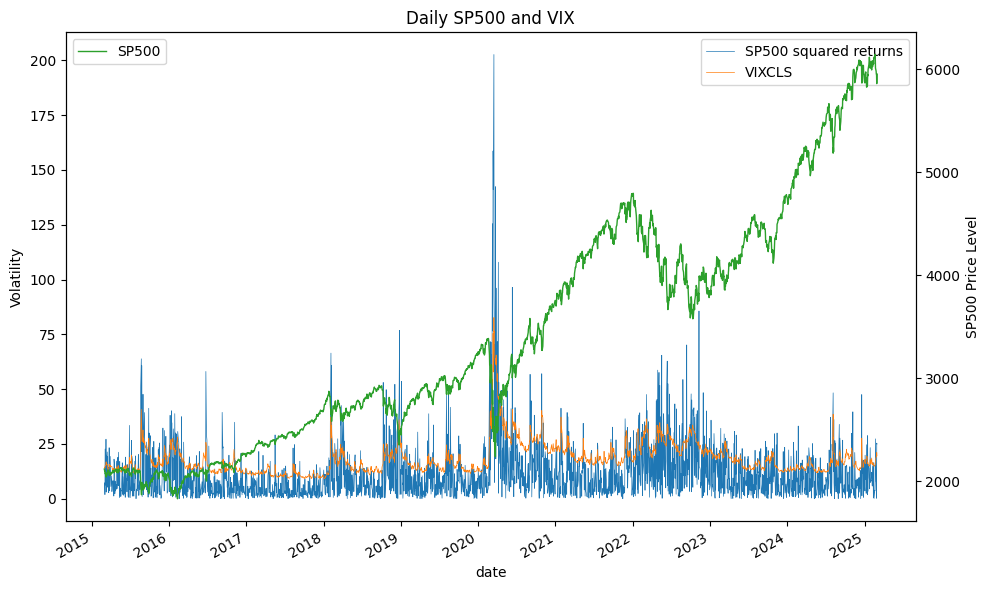

In [17]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE, convert_date=0)
vix = alf('VIXCLS')
sp500_sq = alf('SP500', log=1, diff=1).rename('SP500 squared returns')
sp500 = alf('SP500')
df = pd.concat([100*np.sqrt(252*sp500_sq**2), vix], axis=1, join='inner').dropna()

fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax, lw=.5)
ax.set_ylabel('Volatility')
bx = ax.twinx()
sp500.plot(ax=bx, lw=1, color="C2")
bx.set_ylabel('SP500 Price Level')
plt.title('Daily SP500 and VIX')
plt.legend()
plt.tight_layout()


### Volatility smile
If the assumptions underlying the Black-Scholes-Merton model held exactly, all options on an asset would have the same implied volatility at all times. In practice, implied volatility varies with the strike price and time to maturity. The **volatility smile** refers to this observed pattern, where options with extreme strike prices (both high and low) tend to have higher implied volatilities. Because of put-call parity, the implied volatility of a European call option is the same as that of a European put option when they have the same strike price and time to maturity.

In equity options, the volatility smile generally slopes downward. This means that out-of-the-money puts and in-the-money calls tend to have higher implied volatilities, while out-of-the-money calls and in-the-money puts have lower implied volatilities. This phenomenon is often referred to as a volatility skew. There is a negative correlation between equity prices and volatility, which means that as stock prices fall, volatility increases, and as stock prices rise, volatility decreases.

For foreign currency options, the volatility smile takes a U-shape. Both out-of-the-money and in-the-money options tend to have higher implied volatilities compared to at-the-money options. The volatility of exchange rates is not constant and can be subject to sudden jumps, often driven by central bank actions. These nonconstant volatilities and jumps make extreme price movements more likely.

Traders also often use a volatility term structure, where the implied volatility of an option depends on its time to maturity. When volatility smiles and term structures are combined, they form a **volatility surface**. This surface shows implied volatility as a function of both the strike price and the time to maturity. When quoting option prices, traders interpolate between known implied volatilities to estimate the implied volatility for the option in question. This estimated volatility is then plugged into the Black-Scholes-Merton model to calculate the option price. This approach helps address the fact that the market does not always price options in line with the assumptions of the Black-Scholes-Merton model.

### The "Greeks"

The Greek letters, or **Greeks** as they are often called, are metrics used to measure the sensitivity of option prices to different factors such as changes in the price of the underlying asset, volatility, time decay, and interest rates.


- **Delta** measures the sensitivity to changes in the price of the underlying asset: 

$\Delta_c = e^{-qt} \Phi(d_1)$

$\Delta_p = e^{-qt} [\Phi(d_1) - 1]$


- **Gamma** measures the sensitivity of a portfolio's delta to changes in the price of the underlying asset: 
  
$\Gamma = \dfrac{e^{-qt}}{S \sigma\sqrt{t}}\phi(d_1)$


- **Theta** measures the sensitity to time to expiration

$\Theta_c = -\dfrac{S\sigma e^{-qt}}{2\sqrt{t}}\phi(d_1) - rKe^{-rt}\Phi(d_2) + qSe^{-qt}\Phi(d_1)$

$\Theta_p = -\dfrac{S\sigma e^{-qt}}{2\sqrt{t}}\phi(d_1) + rKe^{-rt}\Phi(-d_2) - qSe^{-qt}\Phi(-d_1)$



- **Vega** measures the sensitivity to the implied volatility
  
$V = S e^{-qt} \sqrt{t} \phi(d_1)$




- **Rho** measures the sensitivity to changes in the level of interest rate 
  
$\rho_c = K t e^{-rt} \Phi(d_2)$

$\rho_p = K t e^{-rt} \Phi(-d_2)$

Any of the Greek letters for a portfolio of derivatives dependent on
the same asset can be calculated as the weighted sum of the Greek letters
for each portfolio component.


The Black-Scholes-Merton analysis can be used to show that
$$\Theta + (r-q) S \Delta + \dfrac{1}{2} \sigma^2 S^2 \Gamma = (r-q) C$$


In [18]:
# Helper to plot a greek over range of stock price S"""
def plot_greek(K, sigma, r, T, greek, S=np.linspace(50, 200, 100),
               ax=None, label='', q=0., c="C0"):
    """helper to plot a greek over range of stock price S"""
    y = [greek(S=s, K=K, sigma=sigma, r=r, T=T, q=q) for s in S]
    ax = ax or plt.gca()
    ax.plot(S, y, color=c)
    #ax.set_xlabel('Stock Price')
    ax.legend([label])

Define and plot options sensitivities

0.5357925584332519
39.73355715246575
0.0158934228609863
-6.727614629584682
44.02299963816157


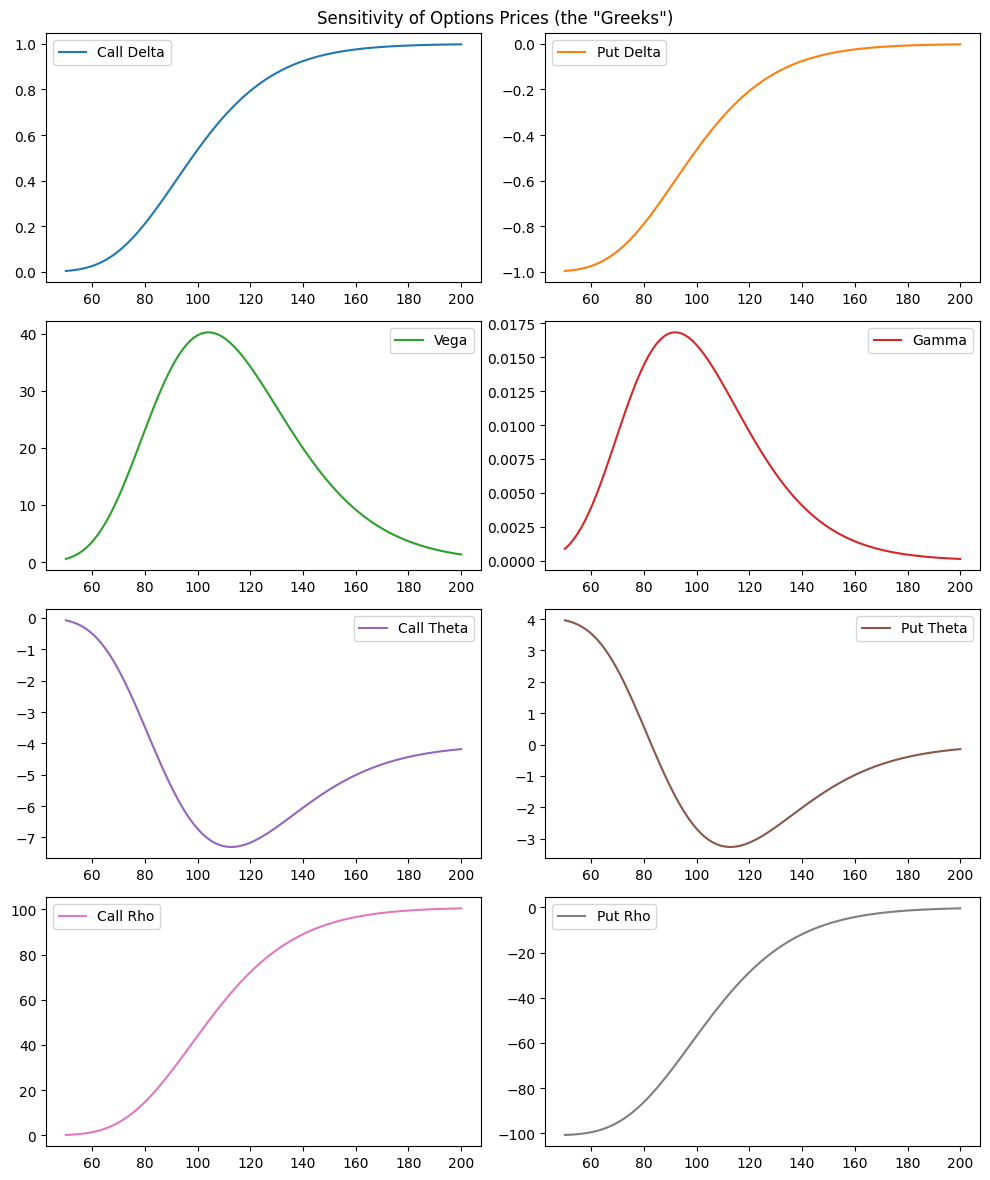

In [19]:
# Plot options sensitivities
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
ax = ax.flatten()

# call option parameters
opt = dict(K=105, r=0.04, sigma=0.25, T=1)

def delta_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return np.exp(-q*T) * stats.norm.cdf(d1)
def delta_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return -np.exp(-q*T) * stats.norm.cdf(-d1)
print(delta_call(S=100, **opt))  # 0.5358

plot_greek(greek=delta_call, label='Call Delta', ax=ax[0], c="C0", **opt)
plot_greek(greek=delta_put, label='Put Delta', ax=ax[1], c="C1", **opt)

def vega(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call or put option delta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return S * np.exp(-q*T) * np.sqrt(T) * stats.norm.pdf(d1)
print(vega(S=100, **opt))  # 39.73

plot_greek(greek=vega, label='Vega', ax=ax[2], c="C2", **opt)

def gamma(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call or put option gamma"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    return np.exp(-q*T) * stats.norm.pdf(d1) / (S * sigma * np.sqrt(T))
print(gamma(S=100, **opt))  # 0.0159

plot_greek(greek=gamma, label='Gamma', ax=ax[3], c="C3", **opt)

def theta_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option theta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return ((-S * np.exp(-q*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)))
            - (r * K * np.exp(-r*T) * stats.norm.cdf(d2)) +
            + (q * S * np.exp(-q*T) * stats.norm.cdf(d1)))
def theta_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option theta"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return ((-S * np.exp(-q*T) * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T)))
            + (r * K * np.exp(-r*T) * stats.norm.cdf(-d2)) +
            - (q * S * np.exp(-q*T) * stats.norm.cdf(-d1)))
print(theta_call(S=100, **opt))  # 6.73

plot_greek(greek=theta_call, label='Call Theta', ax=ax[4], c="C4", **opt)

plot_greek(greek=theta_put, label='Put Theta', ax=ax[5], c="C5", **opt)

def rho_call(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton call option rho"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return K * T * np.exp(-r * T) * stats.norm.cdf(d2)
def rho_put(S, K, sigma, r, T, q=0.):
    """Black-Scholes-Merton put option rho"""
    d1 = _d1(S=S, K=K, sigma=sigma, r=r, T=T, q=q)
    d2 = d1 - sigma * np.sqrt(T)
    return -K * T * np.exp(-r * T) * stats.norm.cdf(-d2)
print(rho_call(S=100, **opt))  # 44

plot_greek(greek=rho_call, label='Call Rho', ax=ax[6], c="C6", **opt)

plot_greek(greek=rho_put, label='Put Rho', ax=ax[7], c="C7", **opt)

plt.suptitle('Sensitivity of Options Prices (the "Greeks")')
plt.tight_layout()

In [20]:
# Check that: theta + r S delta + 1/2 sigma^2 S^2 gamma = r call
S = 100
print(theta_call(S=S, **opt) + opt['r'] * S * delta_call(100, **opt) +
      0.5 * opt['sigma']**2 * S**2 * gamma(S=S, **opt),
      opt['r'] * call(S=S, **opt))

0.3822502482065442 0.38225024820654485


## Monte Carlo simulation

Simulation is an effective way to estimate expectations that are difficult or impossible to compute analytically. Consider a random variable $X$ that can be simulated (for example, from a normal distribution), and a function $g$ that can be evaluated at realizations of $X$. To estimate the expected value of $g(X)$, we take multiple simulated draws. Since these draws are independent and identically distributed (iid), the expectation can be approximated as:

$$
\hat{E}[g(X)] = \frac{1}{b} \sum_{i=1}^{b} g(X_i)
$$

where $b$ is the number of simulated samples. By the Law of Large Numbers (LLN), the approximation improves as $b$ increases:

$$
\lim_{b \to \infty} \hat{E}[g(X)] = E[g(X)]
$$

Additionally, the Central Limit Theorem (CLT) implies that the distribution of the simulated estimate approaches a normal distribution as the number of simulations grows. The variance of the simulated estimate can be approximated by:

$$
V[\hat{E}[g(X)]] = \frac{\sigma^2_b}{b}
$$

where $\sigma^2_b$ is the sample variance. This variance can be estimated as:

$$
\sigma^2_g = \frac{1}{b} \sum_{i=1}^{b} (g(X_i) - E[g(X_i)])^2
$$

which is the standard variance estimator for iid samples. The standard error of the estimate, $\frac{\sigma_g}{\sqrt{b}}$, indicates the accuracy of the approximation. This allows us to adjust $b$ to achieve any desired level of precision.



### Antithetic Variates

Antithetic variates are a technique to improve the accuracy of simulation by generating a second set of random variables that are negatively correlated with the original set of random variables. These pairs of variables are created using a single uniform random number. Each uniform variable $U_i$ generates its counterpart $1 - U_i$, both of which are then mapped through the inverse cumulative distribution function (CDF) to generate correlated random variables. 

Using antithetic variates reduces the simulation error, but only if the function $g(X)$ is monotonic, which ensures that the negative correlation between the paired variables results in reduced error. The benefit of this approach comes from the negative correlation, which decreases the standard error and thus increases the accuracy of the simulation.


### Control Variates

Control variates are another technique to enhance simulation accuracy. A control variate is a derived random variable $h(X_i)$, which is correlated with the primary variable $g(X_i)$ but has a known mean, typically zero. To be effective, a good control variate must satisfy two criteria:

1. It should be computationally inexpensive to construct from the data $x_i$, offering a more cost-effective alternative to increasing the number of simulations.
2. It should exhibit a high correlation with the function $g(X)$, making it useful for reducing the error in the primary estimate.

The optimal parameter $\beta$, which minimizes the approximation error, is typically found using regression:

$$
g(x_i) = \alpha + \beta h(x_i)
$$

By adjusting $\beta$, the control variate technique helps improve the accuracy of the estimated value of $g(X)$.


### Simulating option prices

To simulate the price of a financial option, we assume that the logarithm of the stock price follows a normal distribution. The log of the stock price at time $T$, denoted $s_T$, is given by:

$$
s_T = s_0 + T \left( r_f - \frac{\sigma^2}{2} \right) + \sqrt{T} x_i
$$

where $x_i$ is a random variable sampled from a normal distribution $N(0, \sigma^2)$, $r_f$ is the risk-free rate, and $\sigma^2$ is the variance of the stock return. The final stock price is then $S_T = \exp(s_T)$, and the present value of the option's payoff is:

$$
C = \exp(-r_f T) \max(S_T - K, 0)
$$

where $K$ is the strike price of the option. The expected price of a call option can be estimated by averaging the simulated payoffs:

$$
E[C] = \overline{C} = \frac{1}{b} \sum_{i=1}^{b} C_i
$$

where $C_i$ represents the simulated payoff for each instance. This approach is particularly useful for complex pricing scenarios where analytical solutions may not exist.

In [26]:
# helpers for random number generator and monte carlo simulation
class RNG:
    """Helper to generate random normal variables, with optional antithetic variates"""
    def __init__(self, seed=None, antithetic=False, ppf=stats.norm.ppf):
        self.ppf = ppf
        self.antithetic = antithetic
        self._prev = None   # to track if antithetic pair available to return next
        self.seed = seed
        self.rng = np.random.default_rng(seed)

    def __call__(self, shape=1, **kwargs):
        _shape = (shape, ) if isinstance(shape, int) else shape
        n = np.prod(_shape)
        if self.antithetic:  # generate half as many rv's, by returning 1-rv
            new = int((n + 1) / 2) if self._prev is None else int(n / 2)
            new = self.rng.random((new,))
            rem = 1 - new[:n - len(new) - int(self._prev is not None)]
            last = new[-1] if len(rem) < len(new) else None   # if last pair unused
            out = [] if self._prev is None else [1 - self._prev]
            #out.extend(new)
            #out.extend(rem)
            for x, y in zip(new[:len(rem)], rem):
                out.extend([x, y])
            if last is not None:
                out.extend([last])
            out = np.array(out)
            self._prev = last
        else:
            out = self.rng.random(_shape)
        if shape == 1:
            return self.ppf(out[0], **kwargs)
        else:
            return self.ppf(out.reshape(_shape), **kwargs)

def monte_carlo(rng, S, K, sigma, r, T, control=None):
    """Helper to price European call option by Monte Carlo Simulation
    Args:
      control : True price of European put option, as control variate
    """
    if rng.antithetic:
        label = 'Both' if control else 'Antithetic'
    else:
        label = 'Control' if control else 'Standard'
    result = {}
    for b in [50*4**i for i in range(9)]:
        tic = time.time()
        x = rng(b, scale=sigma)
        s = S * np.exp(T * (r - sigma**2/2) + np.sqrt(T) * x)
        c = np.exp(-r * T) * np.maximum(s - K, 0)
        if control is not None:   # to apply control variate method
            error = np.exp(-r * T) * np.maximum(K - s, 0) - control  # error of put price
            ols = stats.linregress(x=error, y=c)  # compute best hedge to minimize error
            c = c - ols.slope * error
        result[b] = dict(Price=np.mean(c).round(2),
                         StdErr=(np.std(c) / np.sqrt(b)).round(2),
                         elapsed = np.round(time.time() - tic, 4))
    return DataFrame.from_dict(result, orient='index').rename_axis(columns=label)

RNG(antithetic=True)((2, 3))   # generate normal r.v.'s with antithetic variates

array([[-0.72886259,  0.72886259,  0.25403329],
       [-0.25403329, -0.81873243,  0.81873243]])

Standard simulation


In [27]:
S = 2500
K = 2500
sigma = 0.164
r = 0.02
T = 2

seed = 42
rng = RNG(seed=seed)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T)

Standard,Price,StdErr,elapsed
50,297.91,54.77,0.0005
200,247.65,25.97,0.0003
800,283.95,15.23,0.0003
3200,279.62,7.59,0.0004
12800,278.25,3.73,0.0009
51200,279.45,1.85,0.0027
204800,278.93,0.93,0.0112
819200,278.31,0.46,0.0491
3276800,278.59,0.23,0.2490


Antithetic Variates


In [28]:
rng = RNG(seed=seed, antithetic=True)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T)

Antithetic,Price,StdErr,elapsed
50,280.86,54.41,0.0004
200,242.12,25.04,0.0006
800,276.97,14.15,0.0013
3200,284.38,7.63,0.0013
12800,277.30,3.72,0.0014
51200,279.28,1.87,0.0052
204800,278.15,0.93,0.0225
819200,278.46,0.46,0.1279
3276800,278.48,0.23,0.4977


Control Variates


In [29]:
control = put(S, K, sigma, r, T)   # Black-Scholes-Merton put price
rng = RNG(seed=seed)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T, control=control)

Control,Price,StdErr,elapsed
50,263.59,47.04,0.0010
200,251.85,22.76,0.0003
800,287.49,13.52,0.0002
3200,279.92,6.76,0.0003
12800,278.43,3.32,0.0010
51200,279.01,1.64,0.0022
204800,279.02,0.83,0.0109
819200,278.22,0.41,0.0441
3276800,278.64,0.21,0.3454


Both Antithetic and Control Variates


In [30]:
control = put(S, K, sigma, r, T)    # Black-Scholes-Merton put price
rng = RNG(seed=seed, antithetic=True)
monte_carlo(rng, S=S, K=K, sigma=sigma, r=r, T=T, control=control)

Both,Price,StdErr,elapsed
50,286.14,45.71,0.0006
200,227.29,22.03,0.0008
800,277.91,12.32,0.0003
3200,286.51,6.79,0.0008
12800,276.56,3.31,0.0018
51200,279.47,1.66,0.0058
204800,277.88,0.83,0.0244
819200,278.41,0.41,0.1019
3276800,278.41,0.21,0.5569


__References:__

F. Black and M. Scholes, “The Pricing of Options and Corporate Liabilities,” Journal of Political Economy, 81 (May/June 1973): 637–59

R. C. Merton, “Theory of Rational Option Pricing,” Bell Journal of Economics and Management Science 4 (Spring 1973): 141–183. 

Cox, J. C., Ross, S. A., & Rubinstein, M. (1979). Option Pricing: A Simplified Approach. Journal of Financial Economics, 7(3), 229-263. 

Terence Lim, Andrew W. Lo, Robert C. Merton and Myron S. Scholes (2006), "The Derivatives Sourcebook", Foundations and Trends in Finance: Vol. 1: No. 5–6, pp 365-572. http://dx.doi.org/10.1561/0500000005 

FRM Part I Exam Book Financial Markets and Products Ch. 14-15

FRM Part I Exam Book Quantitative Analysis Ch. 13

FRM Part I Exam Book Valuation and Risk Models Ch. 14-16 

FRM Part II Exam Book Market Risk Measurement and Management Ch. 15 